<a href="https://colab.research.google.com/github/Sompote/pile_deep_learning/blob/main/pile_soil_boring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#pile analysis
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style

df_pile=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data/pile_soil_data.xlsx',sheet_name='pile')
df_soil=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data/pile_soil_data.xlsx',sheet_name='soil')
df_soil=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data/pile_soil_data.xlsx',sheet_name='pile_deform')

data_pile=np.array(df_pile)
data_soil=np.array(df_soil)
data_pile_deform=np.array(df_soil)

pile_load=data_pile[:,0:9]
pile_feature=data_pile[:,13:16]
pile_deform=data_pile_deform[:,0:9]



In [8]:
data_soil.shape

(3, 11)

In [24]:
#scale data
x_soil=data_soil
x_feature=pile_feature
x_deform=pile_deform
Y_train=pile_load
sc_x_soil=StandardScaler()
sc_x_feature=StandardScaler()
sc_x_deform=StandardScaler()
sc_Y_train=StandardScaler()



sc = StandardScaler()
sc_f=StandardScaler()

X_train_soil = sc_x_soil.fit_transform(x_soil)
y_train=sc_Y_train.fit_transform(Y_train)
X_feature=sc_x_feature.fit_transform(x_feature)
X_deform=sc_x_deform.fit_transform(x_deform)
X_deform=np.reshape(X_deform,(X_deform.shape[0],X_deform.shape[1],1))
X_train_soil=np.reshape(X_train_soil,(X_train_soil.shape[0],X_train_soil.shape[1],1))

In [25]:
X_train_soil, X_test_soil, X_feature_train, X_feature_test, X_train_deform, X_test_deform,Y_train, Y_test=train_test_split(X_train_soil, X_feature, X_deform,y_train, test_size=0.1)


In [27]:
X_train_deform.shape

(2, 9, 1)

In [38]:
#Model generation part
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError
#from attention import Attention




def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  cnn_output = Conv1D(filters=64, kernel_size=4, activation='relu',name='CNN_layer')(cnn_input)
  cnn_output = Conv1D(filters=64, kernel_size=4, activation='relu')(cnn_output)
  #cnn_output = Attention(units=32)(cnn_output)

  cnn_output = Flatten()(cnn_output)
  cnn_output = Dense(50, activation='linear')(cnn_output)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  return cnn_model

def dense_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='feature_input')
  dense_output = Dense(20,activation='sigmoid')(dense_input)
  dense_output = Dense(100,activation='sigmoid')(dense_input)
  dense_output = Dense(20, activation='sigmoid')(dense_output)
  layer=Dropout(0.2)(dense_output)
  dense_output = Dense(20, activation='linear')(layer)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model



def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='soil_data_input')
  layer = LSTM(20,return_sequences=True)(dense_input)
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(layer)
  dense_output = Dense(200, activation='sigmoid')(layer)
  layer=Dropout(0.2)(layer)
  dense_output = Dense(20, activation='linear')(layer)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def LSTM_model2(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape,name='pile_load_input')
  layer = LSTM(20,return_sequences=True)(dense_input)
  #dense_output = Attention(units=32)(dense_output)
  layer = Flatten()(layer)
  dense_output = Dense(200, activation='sigmoid')(layer)
  layer=Dropout(0.2)(layer)
  dense_output = Dense(20, activation='linear')(layer)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def encoding_model(LSTM_model_soil,LSTM_model_load, cnn_model,latent_dim):
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model_soil.output
  combined_input_LSTM_load = LSTM_model_load.output

  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  layer=Dense(200, activation='sigmoid')(combined_input)
  layer=Dropout(0.2)(layer)
  layer=Dense(dense_input_shape, activation='sigmoid')(layer)
  combined_input2 = concatenate([combined_input_LSTM_load,layer])
  layer=Dense(50, activation='sigmoid')(combined_input2)


  combined_output = Dense(latent_dim, activation='linear')(layer)
  combined_model = Model(inputs=[LSTM_model_soil.input,cnn_model.input,LSTM_model_load.input], outputs=combined_output,name='encoding_model')
  return combined_model


def decoding_model(latent_dim,feature_dim,time_step):
  inputs_l = Input(shape=latent_dim, name='latent')
  layer_int=  Dense(40, activation='sigmoid')(inputs_l)
  layer=Dense(200, activation='sigmoid')(layer_int)
  layer=Dense(100, activation='relu')(layer)
  dense_output = Dense(time_step, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l], outputs=output,name='decoding_model')
  return model

def transformer(encoding_model,decoding_model,feature_dim):
  input_l=encoding_model.output
  print(input_l)
  outputs = decoding_model([input_l])
  print(outputs)
  model = Model(inputs=[encoding_model.input], outputs=outputs)
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train_soil.shape[1])
LSTM_input_shape=(X_train_soil.shape[1],X_train_soil.shape[2])
LSTM2_input_shape=(X_train_deform.shape[1],X_train_deform.shape[2])


feature_dim=X_feature.shape[1]
latent_dim=15
time_step=Y_train.shape[1]
#model_cnn=CNN_model(cnn_input_shape)
model_lstm_soil= LSTM_model(LSTM_input_shape)
mpdel_lstm_load=LSTM_model2(LSTM2_input_shape)
model_dense=dense_model(feature_dim)

#model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_encoding=encoding_model(LSTM_model_soil= model_lstm_soil,LSTM_model_load=mpdel_lstm_load,
                              cnn_model=model_dense,latent_dim=latent_dim)
model_decoding=decoding_model(latent_dim,feature_dim,time_step)
model_transform=transformer(model_encoding,model_decoding,feature_dim)
model_transform.compile(optimizer='adam', loss='mse', metrics=['mae','mape'])
model_transform.summary()


from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=6,restore_best_weights=True)

history=model_transform.fit([X_train_soil,X_feature_train,X_train_deform], Y_train, epochs=500, batch_size=6,validation_data=([X_test_soil,X_feature_test,X_test_deform], Y_test))



KerasTensor(type_spec=TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), name='dense_75/BiasAdd:0', description="created by layer 'dense_75'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), name='decoding_model/dense_79/BiasAdd:0', description="created by layer 'decoding_model'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 soil_data_input (InputLayer)   [(None, 11, 1)]      0           []                               
                                                                                                  
 feature_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 11, 20)       1760        [

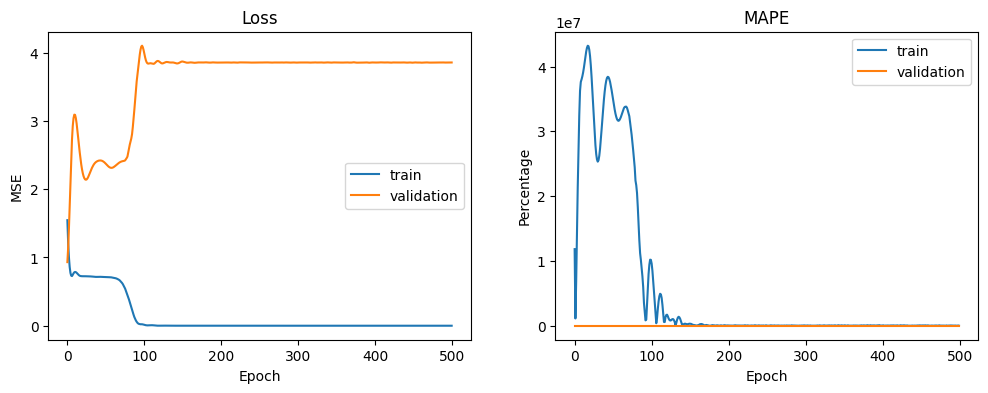

In [39]:
# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 soil_data_input (InputLayer)   [(None, 11, 1)]      0           []                               
                                                                                                  
 feature_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 11, 20)       1760        ['soil_data_input[0][0]']        
                                                                                                  
 dense_69 (Dense)               (None, 100)          400         ['feature_input[0][0]']          
                                                                                           

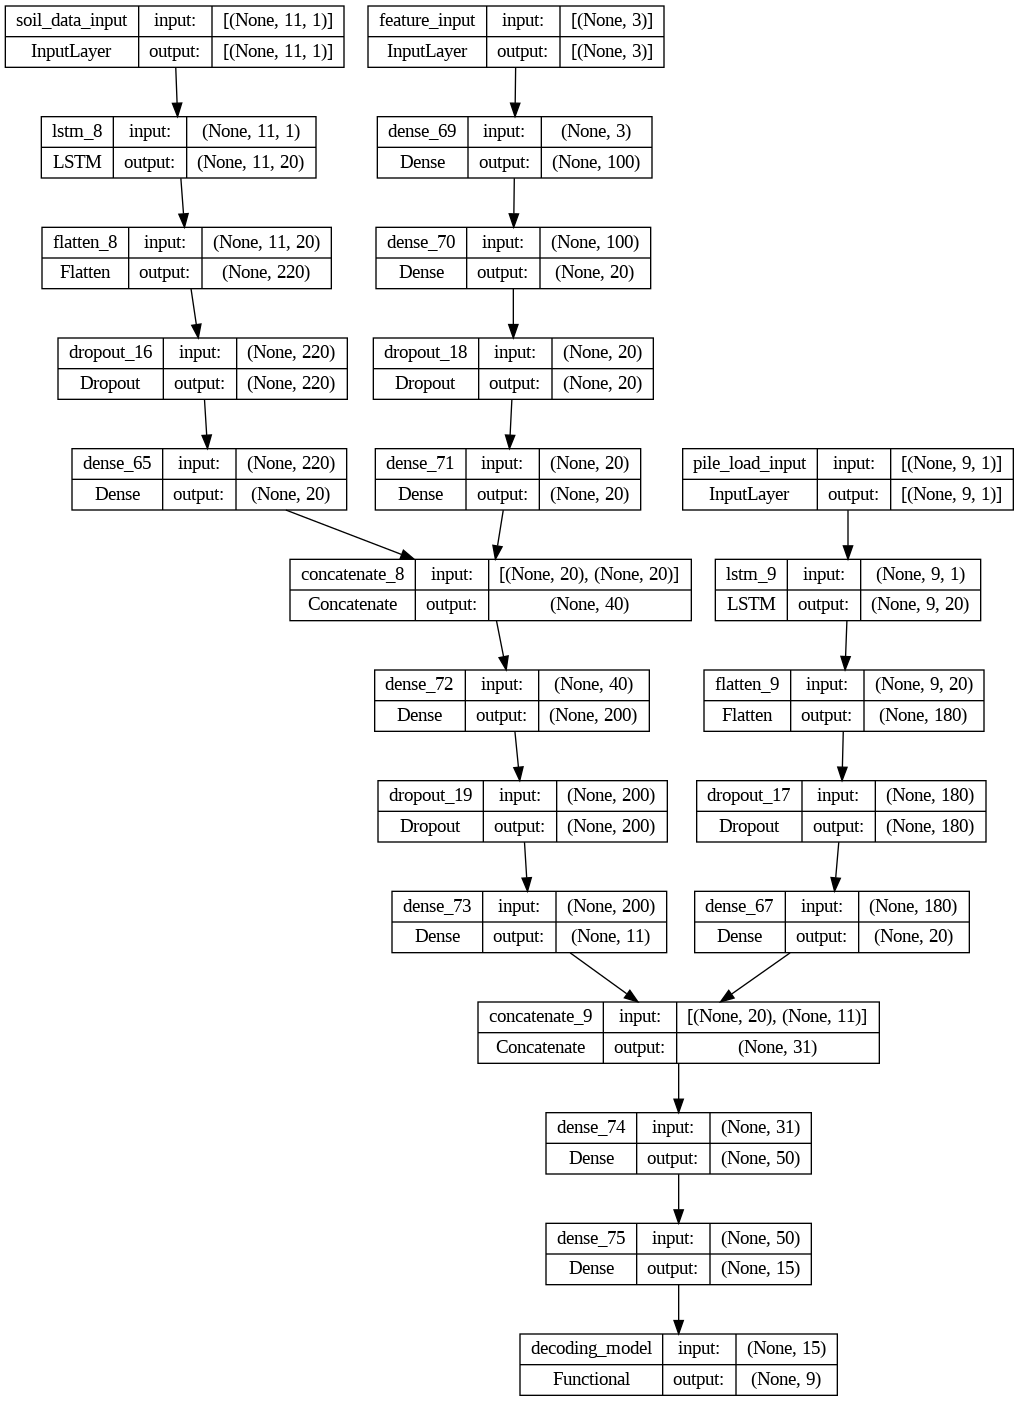

In [40]:
# plot and save your model
import tensorflow as tf
model_transform.summary()
img_file = 'model2.png'
tf.keras.utils.plot_model(model_transform, to_file=img_file, show_shapes=True, show_layer_names=True)

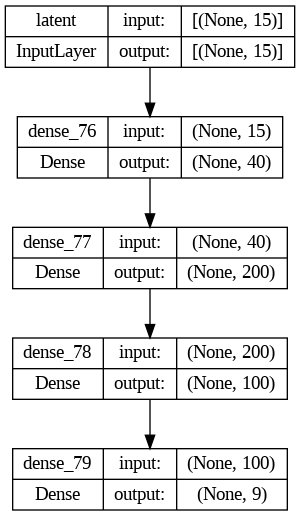

In [41]:
tf.keras.utils.plot_model(model_decoding, to_file=img_file, show_shapes=True, show_layer_names=True)